<a href="https://colab.research.google.com/github/shivammehta007/QuestionGenerator/blob/master/Answer_only_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Testing Classifier Model

In [1]:
# Essential Installation for working of notebook
!pip install -U tqdm

Requirement already up-to-date: tqdm in /usr/local/lib/python3.6/dist-packages (4.45.0)


### Imports

In [2]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spacy
import seaborn as sns
import torch
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from tqdm.auto import tqdm, trange
from wordcloud import WordCloud
from xgboost import XGBClassifier

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Environment Setup 

In [0]:
SEED=1234
def seed_all(seed=1234):
    """Seed the results for duplication"""
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_all(SEED)

In [0]:
tqdm.pandas()
nlp = spacy.load("en_core_web_sm") 

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
DATASET_LOCATION = '/content/drive/My Drive/Data/GrammarDataset.csv'

## Dataset Overview

In [0]:
original_dataset = pd.read_csv(DATASET_LOCATION, sep="\t")

In [8]:
original_dataset.head()

,Question,key,answer,Type of Question,Sub Section
0,She _________________ some chocolates to the p...,bring,She brought some chocolates to the party.,irregular verb,past simple
1,I _________________ a new song on the radio.,hear,I heard a new song on the radio.,irregular verb,past simple
2,I _________________ three books last week.,read,I read three books last week.,irregular verb,past simple
3,They _________________ French to the waitress.,speak,They spoke French to the waitress.,irregular verb,past simple
4,He _________________ during the class but now ...,understand,He understood during the class but now he doe...,irregular verb,past simple


In [9]:
original_dataset.dtypes

Question            object
key                 object
answer              object
Type of Question    object
Sub Section         object
dtype: object

#### EDA

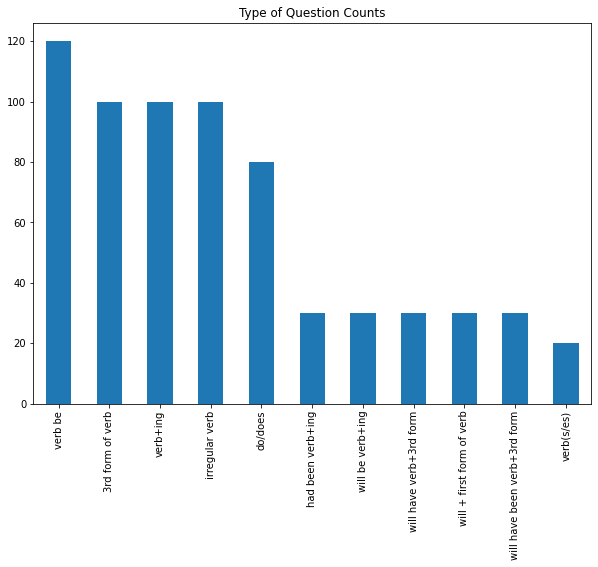

In [10]:
ax, fig = plt.subplots(figsize=(10, 7))
question_class = original_dataset["Type of Question"].value_counts()
question_class.plot(kind='bar')
plt.title('Type of Question Counts')
plt.show()

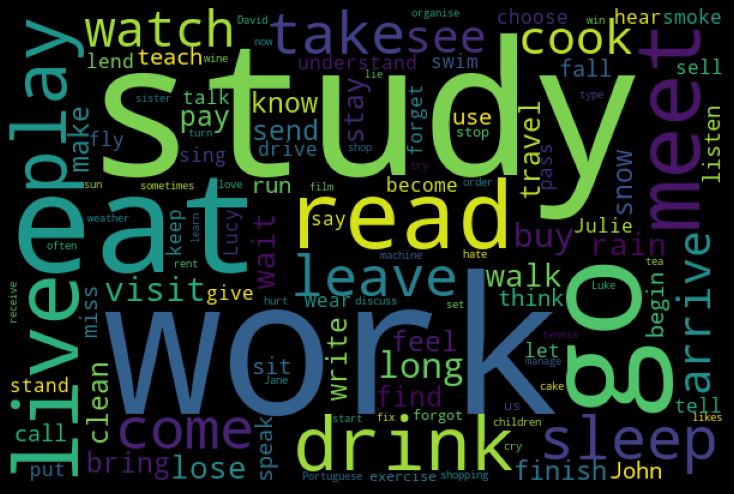

In [11]:
insincere_wordcloud = WordCloud(width=600, height=400).generate(" ".join(original_dataset["key"]))
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(insincere_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

### PreProcessing

In [0]:
def preprocessor(dataset):
    # Replace continuous underscores with single one
    dataset["Question"] = dataset["Question"].str.replace("[_]{2,}", "_")
    # Remove Brackets
    dataset["Question"] = dataset["Question"].str.replace("[\)\(]", "")
    # Strip whitespaces
    dataset["Question"] = dataset["Question"].apply(lambda x: x.strip())
    # Convert all text to lowercase
    for columns in dataset.columns:
        dataset[columns] = dataset[columns].str.lower() 

    return dataset

In [0]:
original_dataset = preprocessor(original_dataset)

In [14]:
original_dataset.columns

Index(['Question', 'key', 'answer', 'Type of Question', 'Sub Section'], dtype='object')

#### Encoding Labels

In [0]:
label_encoder = LabelEncoder()
original_dataset["Type of Question"] = label_encoder.fit_transform(original_dataset["Type of Question"])

#### Split Training and Testing Data

In [0]:
X_train_orig_dataset, X_test_orig_dataset, y_train_orig_dataset, y_test_orig_dataset = train_test_split(original_dataset["answer"], original_dataset["Type of Question"], random_state=SEED, test_size=0.15)

In [17]:
X_train_orig_dataset.shape, X_test_orig_dataset.shape, y_train_orig_dataset.shape, y_test_orig_dataset.shape

((569,), (101,), (569,), (101,))

## Experiments:

In [18]:
X_train_orig_dataset.head()

271                             how do they get to work?
488    we were late for the plane because we had forg...
131                                   we aren't thirsty.
643    he will have been cooking, so the kitchen will...
155                                   are you in a cafe?
Name: answer, dtype: object

### Experimentation Setup

#### Models

In [0]:
text_vectorizers = [
                    ('CountVectorizer', CountVectorizer(tokenizer=lambda x: x.split())), 
                    ('TfIdFVectorize', TfidfVectorizer(tokenizer=lambda x: x.split()))
                ]
classifiers = [
               ('MultiNomial Naive Bais', MultinomialNB(alpha=0.1)),
               ('SVM', SVC()),
               ('LogisticRegression', LogisticRegression(max_iter=5000)), 
               ('RandomForest', RandomForestClassifier()), 
               ('XGBClassifier', XGBClassifier(random_state=SEED, learning_rate=0.01))
            ]

In [0]:
def check_classification(X_train, y_train, X_test, y_test):

    # Result DataFrame
    result_dataframe = pd.DataFrame({
        'Vectorizer': [name for name, model in text_vectorizers]
        }, columns = ['Vectorizer'] + [name for name, model in classifiers])
    result_dataframe.set_index('Vectorizer', inplace=True)


    best_score = 0
    best_model = None
    best_pipe = None
    for classifier_name, classifier in classifiers:
        for text_vectorizer_name, text_vectorizer in text_vectorizers:
            pipe = Pipeline(steps=[
                                ('text_vec', text_vectorizer),
                                ('class', classifier)
            ])
            pipe.fit(X_train, y_train)
            f1_measure = f1_score(pipe.predict(X_test), y_test, average='micro')
            # print('Model : {} -> {}:  accuracy: {:.4f}'.format(text_vectorizer_name, classifier_name, acc*100))
            result_dataframe[classifier_name][text_vectorizer_name] = '{:.4f}'.format(f1_measure)

            if f1_measure > best_score:
                best_score = f1_measure
                best_pipe = pipe
                best_model = '{} -> {}'.format(text_vectorizer_name, classifier_name)
    # TODO: Remove while actually writing the code Code for Debugging
    # analyzer = best_pipe['text_vec'].build_analyzer()
    # print(analyzer("i _ the steak for dinner.  choose  i chose the steak for dinner."))
    # print(analyzer("words#i _ words#_ words#the words#steak words#for words#dinner words#. words#  words#choose words#  words#i words#chose words#the words#steak words#for words#dinner words#."))
    # with np.printoptions(threshold=np.inf):
    #     print("First: {}".format(best_pipe['text_vec'].transform(["i _ the steak for dinner.  choose  i chose the steak for dinner."])[0]))
    #     print("Second: {}".format(best_pipe['text_vec'].transform(["words#i words#_ words#the words#steak words#for words#dinner words#. words#  words#choose words#  words#i words#chose words#the words#steak words#for words#dinner words#."])[0]))


    print("\n\nBest F1 Measure was: {:.4f} with the Model: {}".format(best_score, best_model))
    return result_dataframe

#### Result Placeholder

In [0]:
result_dataframe = pd.DataFrame({
        'Vectorizer': [name for name, model in text_vectorizers]
        }, columns = ['Vectorizer'] + [name for name, model in classifiers])
result_dataframe.set_index('Vectorizer', inplace=True)

results = []

#### N-Gram Generator

In [22]:
from itertools import cycle
from collections import deque

def ngrams(sentence, n=2):
    words = [word.text for word in nlp(sentence)]
    d = deque(maxlen=n)
    d.extend(words[:n])
    words = words[n:]
    results = []
    for window, word in zip(cycle((d,)), words):
        results.append([ngram for ngram in window])
        d.append(word)
    results.append([ngram for ngram in d])

    return results

ngrams("this sentence is a test sentence to check ngrams")

[['this', 'sentence'],
 ['sentence', 'is'],
 ['is', 'a'],
 ['a', 'test'],
 ['test', 'sentence'],
 ['sentence', 'to'],
 ['to', 'check'],
 ['check', 'ngrams']]

In [23]:
for n in range(2,5):
    print(" {}-Grams:".format(n), end=" ")
    print(ngrams("Hello World! This is a test example of N-Gram generator", n))

 2-Grams: [['Hello', 'World'], ['World', '!'], ['!', 'This'], ['This', 'is'], ['is', 'a'], ['a', 'test'], ['test', 'example'], ['example', 'of'], ['of', 'N'], ['N', '-'], ['-', 'Gram'], ['Gram', 'generator']]
 3-Grams: [['Hello', 'World', '!'], ['World', '!', 'This'], ['!', 'This', 'is'], ['This', 'is', 'a'], ['is', 'a', 'test'], ['a', 'test', 'example'], ['test', 'example', 'of'], ['example', 'of', 'N'], ['of', 'N', '-'], ['N', '-', 'Gram'], ['-', 'Gram', 'generator']]
 4-Grams: [['Hello', 'World', '!', 'This'], ['World', '!', 'This', 'is'], ['!', 'This', 'is', 'a'], ['This', 'is', 'a', 'test'], ['is', 'a', 'test', 'example'], ['a', 'test', 'example', 'of'], ['test', 'example', 'of', 'N'], ['example', 'of', 'N', '-'], ['of', 'N', '-', 'Gram'], ['N', '-', 'Gram', 'generator']]


#### Sample Generator

In [0]:
def get_input_samples(X, y, n=5):
    results = []
    for i in random.sample(range(len(X) - 1), n):
        results.append("{} --> {} ".format(X.iloc[i], label_encoder.inverse_transform([y.iloc[i]])))

    return results

### Experiment 1:  Word#\$\{$words_i$\}
Concatenating Question + key + answer in a Bag Of Words Approach \\
No Feature Engineering

In [0]:
experiment_text = "Concatenating question + key + answer. like word#word_i"

#### Preprocessing

In [0]:
X_train = X_train_orig_dataset
y_train = y_train_orig_dataset
X_test = X_test_orig_dataset
y_test = y_test_orig_dataset

In [27]:
def add_word_template(text):
    tokens = nlp(text)
    text = []
    for token in tokens:
        text.append("words#{}".format(token.text))

    return " ".join(text)

add_word_template("i _ the steak for dinner.  choose  i chose the steak for dinner.")

'words#i words#_ words#the words#steak words#for words#dinner words#. words#  words#choose words#  words#i words#chose words#the words#steak words#for words#dinner words#.'

In [28]:
X_train = X_train.progress_apply(add_word_template)
X_test = X_test.progress_apply(add_word_template)

#### Input Samples

In [29]:
get_input_samples(X_train, y_train)

["words#they words#had words#n't words#eaten words#so words#we words#went words#to words#a words#restaurant words#. --> ['3rd form of verb'] ",
 "words#when words#are words#you words#leaving words#? --> ['verb+ing'] ",
 "words#they words#live words#in words#london words#. --> ['verb(s/es)'] ",
 "words#how words#long words#had words#he words#been words#playing words#football words#when words#he words#was words#injured words#? --> ['had been verb+ing'] ",
 "words#had words#she words#seen words#the words#film words#already words#? --> ['3rd form of verb'] "]

#### Experimentation Results

In [30]:
result = check_classification(X_train, y_train, X_test, y_test)
results.append((experiment_text, result))
result

# First:   (0, 24)	1
#   (0, 193)	1
#   (0, 194)	1
#   (0, 257)	2
#   (0, 356)	2
#   (0, 447)	2
#   (0, 851)	2
#   (0, 912)	2
# Second:   (0, 24)



Best F1 Measure was: 0.8218 with the Model: CountVectorizer -> RandomForest


,MultiNomial Naive Bais,SVM,LogisticRegression,RandomForest,XGBClassifier
Vectorizer,,,,,
CountVectorizer,0.8119,0.7921,0.8020,0.8218,0.7525
TfIdFVectorize,0.7822,0.8119,0.8020,0.7624,0.7426


### Experiment 2: word_pos#\$\{$word_i$\}_\$\{$pos_i$\}
With Word and POS tags, token.tag_ gives a detailed POS tag where we can distinguish between forms of verb. \\
More Information https://spacy.io/api/annotation#pos-tagging about the tags

In [0]:
experiment_text = "Adding Pos Tags along with word word_pos#{word_i}_{pos_i} + k#tags + a#tags Unigrams"

#### Preprocessing

In [0]:
X_train = X_train_orig_dataset
y_train = y_train_orig_dataset
X_test = X_test_orig_dataset
y_test = y_test_orig_dataset

In [33]:
def add_word_pos_template(text):
    tokens = nlp(text)
    text = []
    for token in tokens:
        text.append("word_pos#{}_{}".format(token.text, token.tag_))

    return " ".join(text)

# Testing method
test_sentence = "Testing the Pos Tagger in this sentence let's see how it works!".lower()
add_word_pos_template(test_sentence)

"word_pos#testing_VBG word_pos#the_DT word_pos#pos_NN word_pos#tagger_NN word_pos#in_IN word_pos#this_DT word_pos#sentence_NN word_pos#let_VB word_pos#'s_PRP word_pos#see_VB word_pos#how_WRB word_pos#it_PRP word_pos#works_VBZ word_pos#!_."

In [34]:
X_train = X_train.progress_apply(add_word_pos_template)
X_test = X_test.progress_apply(add_word_pos_template)

#### Input Samples

In [35]:
get_input_samples(X_train, y_train)

["word_pos#she_PRP word_pos#loves_VBZ word_pos#chocolate_NN word_pos#._. --> ['verb(s/es)'] ",
 "word_pos#what_WP word_pos#was_VBD word_pos#that_DT word_pos#noise_NN word_pos#?_. --> ['verb be'] ",
 "word_pos#will_MD word_pos#they_PRP word_pos#come_VB word_pos#tomorrow_NN word_pos#?_. --> ['will + first form of verb'] ",
 "word_pos#where_WRB word_pos#are_VBP word_pos#we_PRP word_pos#?_. --> ['verb be'] ",
 "word_pos#she_PRP word_pos#'s_VBZ word_pos#eating_VBG word_pos#chocolate_NN word_pos#._. --> ['verb+ing'] "]

#### Experimentation Results

In [36]:
result = check_classification(X_train, y_train, X_test, y_test)
results.append((experiment_text, result))
result



Best F1 Measure was: 0.8416 with the Model: CountVectorizer -> MultiNomial Naive Bais


,MultiNomial Naive Bais,SVM,LogisticRegression,RandomForest,XGBClassifier
Vectorizer,,,,,
CountVectorizer,0.8416,0.7822,0.8020,0.8020,0.7327
TfIdFVectorize,0.7822,0.8416,0.8218,0.7525,0.7228


### Experiment 3: pos#\$\{$pos_i$\} 
With just POS

In [0]:
experiment_text = "Classifying based on POS tags pos#{pos_i}"

#### Preprocessing

In [0]:
X_train = X_train_orig_dataset
y_train = y_train_orig_dataset
X_test = X_test_orig_dataset
y_test = y_test_orig_dataset

In [39]:
def add_pos_template(text):
    tokens = nlp(text)
    text = []
    for token in tokens:
        text.append("pos#{}".format(token.tag_))

    return " ".join(text)

# Testing method
test_sentence = "Testing the Pos Tagger in this sentence let's see how it works!".lower()
add_pos_template(test_sentence)

'pos#VBG pos#DT pos#NN pos#NN pos#IN pos#DT pos#NN pos#VB pos#PRP pos#VB pos#WRB pos#PRP pos#VBZ pos#.'

In [40]:
X_train = X_train.progress_apply(add_pos_template)
X_test = X_test.progress_apply(add_pos_template)

#### Input Samples

In [41]:
get_input_samples(X_train, y_train)

["pos#WP pos#MD pos#PRP pos#VB pos#VBN pos#IN pos#DT pos#NN pos#IN pos#DT pos#NN pos#. --> ['will have verb+3rd form'] ",
 "pos#PRP pos#VBP pos#RB pos#VB pos#NN pos#. --> ['do/does'] ",
 "pos#WP pos#VBD pos#DT pos#NN pos#. --> ['verb be'] ",
 "pos#WDT pos#NN pos#MD pos#DT pos#NN pos#VB pos#NN pos#. --> ['will + first form of verb'] ",
 "pos#PRP pos#VBD pos#IN pos#DT pos#NN pos#TO pos#VB pos#IN pos#DT pos#NN pos#. --> ['irregular verb'] "]

#### Experimentation Results

In [42]:
result = check_classification(X_train, y_train, X_test, y_test)
results.append((experiment_text, result))
result



Best F1 Measure was: 0.8515 with the Model: TfIdFVectorize -> RandomForest


,MultiNomial Naive Bais,SVM,LogisticRegression,RandomForest,XGBClassifier
Vectorizer,,,,,
CountVectorizer,0.7129,0.8317,0.8317,0.8416,0.8515
TfIdFVectorize,0.7426,0.8317,0.8317,0.8515,0.8119


### Experiment 4: word#{$word_i$} word_pos#\${$word_i$}_\${$pos_i$}

In [0]:
experiment_text = "Combining word and word_pos_tags"

#### Preprocessing

In [47]:
def add_word_and_word_pos_tag_template(text):
    tokens = nlp(text)
    text = []
    for token in tokens:
        text.append("word#{} word_pos##{}_{}".format(token.text, token.text, token.tag_))

    return " ".join(text)

add_word_and_word_pos_tag_template("This is a test sentence! We will see the difference between playing and played")

'word#This word_pos##This_DT word#is word_pos##is_VBZ word#a word_pos##a_DT word#test word_pos##test_NN word#sentence word_pos##sentence_NN word#! word_pos##!_. word#We word_pos##We_PRP word#will word_pos##will_MD word#see word_pos##see_VB word#the word_pos##the_DT word#difference word_pos##difference_NN word#between word_pos##between_IN word#playing word_pos##playing_VBG word#and word_pos##and_CC word#played word_pos##played_VBD'

In [0]:
X_train = X_train_orig_dataset.apply(lambda x: add_word_and_word_pos_tag_template(x))
y_train = y_train_orig_dataset
X_test = X_test_orig_dataset.apply(lambda x: add_word_and_word_pos_tag_template(x))
y_test = y_test_orig_dataset

#### Input Samples

In [50]:
get_input_samples(X_train, y_train)

["word#mrs word_pos##mrs_NNP word#. word_pos##._NNP word#brown word_pos##brown_NNP word#was word_pos##was_VBD word#n't word_pos##n't_RB word#walking word_pos##walking_VBG word#in word_pos##in_IN word#the word_pos##the_DT word#garden word_pos##garden_NN word#. word_pos##._. --> ['verb+ing'] ",
 "word#she word_pos##she_PRP word#told word_pos##told_VBD word#me word_pos##me_PRP word#that word_pos##that_IN word#she word_pos##she_PRP word#had word_pos##had_VBD word#studied word_pos##studied_VBN word#a word_pos##a_DT word#lot word_pos##lot_NN word#before word_pos##before_IN word#the word_pos##the_DT word#exam word_pos##exam_NN word#. word_pos##._. --> ['3rd form of verb'] ",
 "word#lucy word_pos##lucy_NNP word#has word_pos##has_VBZ word#n't word_pos##n't_RB word#done word_pos##done_VBN word#her word_pos##her_PRP$ word#homework word_pos##homework_NN word#. word_pos##._. --> ['3rd form of verb'] ",
 "word#she word_pos##she_PRP word#said word_pos##said_VBD word#that word_pos##that_IN word#she wo

#### Experimentation Results

In [51]:
result = check_classification(X_train, y_train, X_test, y_test)
results.append((experiment_text, result))
result



Best F1 Measure was: 0.8317 with the Model: CountVectorizer -> LogisticRegression


,MultiNomial Naive Bais,SVM,LogisticRegression,RandomForest,XGBClassifier
Vectorizer,,,,,
CountVectorizer,0.8119,0.8020,0.8317,0.7921,0.7327
TfIdFVectorize,0.7723,0.8218,0.8218,0.7822,0.7327


### Experiment 5: ngram#{$word_i$}_{$word_{i+1}$}

In [0]:
experiment_text = "Adding bigrams of words bigram#{word_i}_{word_i+1}"

#### Preprocessing

In [53]:
def add_ngram_template(text, n=2):
    tokens = ngrams(text, n)
    text = []
    for token in tokens:
        text.append("ngram#{}".format("_".join(token)))

    return " ".join(text)

add_ngram_template("This is a test sentence! We will see the difference between playing and played")

'ngram#This_is ngram#is_a ngram#a_test ngram#test_sentence ngram#sentence_! ngram#!_We ngram#We_will ngram#will_see ngram#see_the ngram#the_difference ngram#difference_between ngram#between_playing ngram#playing_and ngram#and_played'

In [0]:
X_train = X_train_orig_dataset.apply(lambda x: add_ngram_template(x))
y_train = y_train_orig_dataset
X_test = X_test_orig_dataset.apply(lambda x: add_ngram_template(x))
y_test = y_test_orig_dataset

#### Input Samples

In [55]:
get_input_samples(X_train, y_train)

["ngram#we_are ngram#are_n't ngram#n't_watching ngram#watching_tv ngram#tv_at ngram#at_the ngram#the_moment ngram#moment_. --> ['verb+ing'] ",
 "ngram#they_do ngram#do_n't ngram#n't_have ngram#have_a ngram#a_car ngram#car_. --> ['do/does'] ",
 "ngram#does_john ngram#john_come ngram#come_from ngram#from_new ngram#new_zealand ngram#zealand_? --> ['do/does'] ",
 "ngram#the_house ngram#house_has ngram#has_been ngram#been_sold ngram#sold_. --> ['irregular verb'] ",
 "ngram#mr_. ngram#._blue ngram#blue_was ngram#was_n't ngram#n't_drinking ngram#drinking_coffee ngram#coffee_in ngram#in_the ngram#the_library ngram#library_. --> ['verb+ing'] "]

#### Experimentation Results

In [56]:
result = check_classification(X_train, y_train, X_test, y_test)
results.append((experiment_text, result))
result



Best F1 Measure was: 0.7822 with the Model: CountVectorizer -> MultiNomial Naive Bais


,MultiNomial Naive Bais,SVM,LogisticRegression,RandomForest,XGBClassifier
Vectorizer,,,,,
CountVectorizer,0.7822,0.4455,0.6535,0.5644,0.4851
TfIdFVectorize,0.7129,0.5149,0.6535,0.6139,0.4950


### Experiment 6: ngrampos#{$pos_i$}_{$pos_{i+1}$}

In [0]:
experiment_text = "Adding bigrams of pos tags ngrampos#{pos_i}_{pos_i+1}"

#### Preprocessing

In [58]:
def add_ngram_pos_template(text, n=2):
    tokens = nlp(text)
    text = []
    for token in tokens:
        text.append("{}".format(token.tag_))

    text = " ".join(text)

    tokens = ngrams(text, n)
    text = []
    for token in tokens:
        text.append("ngrampos#{}".format("_".join(token)))

    return " ".join(text)

add_ngram_pos_template("This is a test sentence! We will see the difference between playing and played")

'ngrampos#DT_VBZ ngrampos#VBZ_DT ngrampos#DT_NN ngrampos#NN_NN ngrampos#NN_. ngrampos#._PRP ngrampos#PRP_MD ngrampos#MD_VB ngrampos#VB_DT ngrampos#DT_NN ngrampos#NN_IN ngrampos#IN_VBG ngrampos#VBG_CC ngrampos#CC_VBD'

In [0]:
X_train = X_train_orig_dataset.apply(lambda x: add_ngram_pos_template(x))
y_train = y_train_orig_dataset
X_test = X_test_orig_dataset.apply(lambda x: add_ngram_pos_template(x))
y_test = y_test_orig_dataset

#### Input Samples

In [60]:
get_input_samples(X_train, y_train)

["ngrampos#__SP ngrampos#SP_PRP ngrampos#PRP_VBD ngrampos#VBD_DT ngrampos#DT_JJ ngrampos#JJ_NN ngrampos#NN_IN ngrampos#IN_DT ngrampos#DT_NN ngrampos#NN_. --> ['irregular verb'] ",
 "ngrampos#PRP_MD ngrampos#MD_VBN ngrampos#VBN_DT ngrampos#DT_JJ ngrampos#JJ_JJ ngrampos#JJ_NN ngrampos#NN_IN ngrampos#IN_PRP$ ngrampos#PRP$_NN ngrampos#NN_, ngrampos#,_CC ngrampos#CC_PRP ngrampos#PRP_VBD ngrampos#VBD_JJ ngrampos#JJ_TO ngrampos#TO_VB ngrampos#VB_PRP ngrampos#PRP_. --> ['irregular verb'] ",
 "ngrampos#WRB_VBP ngrampos#VBP_PRP ngrampos#PRP_VBN ngrampos#VBN_RP ngrampos#RP_. ngrampos#._VBP ngrampos#VBP_PRP ngrampos#PRP_VBG ngrampos#VBG_. --> ['irregular verb'] ",
 "ngrampos#PRP_VBD ngrampos#VBD_VBN ngrampos#VBN_CD ngrampos#CD_NNS ngrampos#NNS_WRB ngrampos#WRB_PRP ngrampos#PRP_VBD ngrampos#VBD_PRP$ ngrampos#PRP$_NN ngrampos#NN_. --> ['irregular verb'] ",
 "ngrampos#PRP_VBP ngrampos#VBP_DT ngrampos#DT_NN ngrampos#NN_. --> ['verb be'] "]

#### Experimentation Results

In [61]:
result = check_classification(X_train, y_train, X_test, y_test)
results.append((experiment_text, result))
result



Best F1 Measure was: 0.8416 with the Model: CountVectorizer -> SVM


,MultiNomial Naive Bais,SVM,LogisticRegression,RandomForest,XGBClassifier
Vectorizer,,,,,
CountVectorizer,0.7723,0.8416,0.8317,0.8317,0.8020
TfIdFVectorize,0.7921,0.8218,0.8218,0.8020,0.7723


# Results

In [62]:
from IPython.display import display, HTML

for i, (description, result) in enumerate(results):
    print("Experiment {}:".format(i+1))
    print(description)
    display(HTML(result.to_html()))
    print("\n\n")

Experiment 1:
Concatenating question + key + answer. like word#word_i


,MultiNomial Naive Bais,SVM,LogisticRegression,RandomForest,XGBClassifier
Vectorizer,,,,,
CountVectorizer,0.8119,0.7921,0.8020,0.8218,0.7525
TfIdFVectorize,0.7822,0.8119,0.8020,0.7624,0.7426





Experiment 2:
Adding Pos Tags along with word word_pos#{word_i}_{pos_i} + k#tags + a#tags Unigrams


,MultiNomial Naive Bais,SVM,LogisticRegression,RandomForest,XGBClassifier
Vectorizer,,,,,
CountVectorizer,0.8416,0.7822,0.8020,0.8020,0.7327
TfIdFVectorize,0.7822,0.8416,0.8218,0.7525,0.7228





Experiment 3:
Classifying based on POS tags pos#{pos_i}


,MultiNomial Naive Bais,SVM,LogisticRegression,RandomForest,XGBClassifier
Vectorizer,,,,,
CountVectorizer,0.7129,0.8317,0.8317,0.8416,0.8515
TfIdFVectorize,0.7426,0.8317,0.8317,0.8515,0.8119





Experiment 4:
Combining word and word_pos_tags


,MultiNomial Naive Bais,SVM,LogisticRegression,RandomForest,XGBClassifier
Vectorizer,,,,,
CountVectorizer,0.8119,0.8020,0.8317,0.7921,0.7327
TfIdFVectorize,0.7723,0.8218,0.8218,0.7822,0.7327





Experiment 5:
Adding bigrams of words bigram#{word_i}_{word_i+1}


,MultiNomial Naive Bais,SVM,LogisticRegression,RandomForest,XGBClassifier
Vectorizer,,,,,
CountVectorizer,0.7822,0.4455,0.6535,0.5644,0.4851
TfIdFVectorize,0.7129,0.5149,0.6535,0.6139,0.4950





Experiment 6:
Adding bigrams of pos tags ngrampos#{pos_i}_{pos_i+1}


,MultiNomial Naive Bais,SVM,LogisticRegression,RandomForest,XGBClassifier
Vectorizer,,,,,
CountVectorizer,0.7723,0.8416,0.8317,0.8317,0.8020
TfIdFVectorize,0.7921,0.8218,0.8218,0.8020,0.7723


# Summary

After these series of experiments, we could distinguish the important featues



1.   Q/K/A Tagging was one of the most important feature
2.   POS tagging with different form of verbs improved the performance over
3.   Combination of QKA and POS tag was is an important feature too
4.   N-Grams (bi) were not that effective while classifying with this data
5.   Random Forest, Logistic Regression and XGBClassifier all these three can be a valid choice while selecting classifier for this classification

